# DEMO Aritificial Intelligence Project - J. Tomczak and D. Rudy

This demo demonstrates the process of loading and evaluating a pre-trained TensorFlow model on a test dataset of audio files. The workflow includes:

- **Loading Test Data**: Retrieving filenames of test audio files and creating TensorFlow datasets.
- **Preprocessing Data**: Mapping file paths to their corresponding waveforms and spectrograms, and resizing images to the required dimensions.
- **Loading the Model**: Loading a pre-trained Keras model for digit recognition.
- **Evaluating the Model**: Predicting labels for the test dataset and calculating the accuracy.
- **Visualizing Results**: Plotting spectrograms of test audio samples along with their predicted and true labels.

In [1]:
import os
import importlib
import tensorflow as tf
from funcs import *

import funcs
importlib.reload(funcs)

# Set TensorFlow to allow GPU memory growth
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2025-01-25 15:07:58.203632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 15:07:58.257761: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 15:07:58.258697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 15:07:59.093940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Check Hardware Accelerator

In [2]:
# Check number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2025-01-25 15:07:59.982816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-25 15:07:59.983406: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Load test filenames

In [3]:
# Get a list of all filenames in the test data directory
filenames = tf.io.gfile.glob(str('data_demo') + '/*')

# Print the number of samples and an example filename
print('Number of all test samples: ', len(filenames))
print('Example filename: ', filenames[0])

Number of all test samples:  10
Example filename:  data_demo/6_35_0.wav


### Create dataset with and transform it to spectograms with coresponding labels

In [4]:
# Set AUTOTUNE for optimizing data loading
AUTOTUNE = tf.data.AUTOTUNE

# Create a dataset from the training file paths
files_ds = tf.data.Dataset.from_tensor_slices(filenames)

# Map the file paths to their corresponding waveforms and labels
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

### Load the model

In [5]:
model = tf.keras.models.load_model('saved_models/digits_model.keras')

### Resize the spectrogram images to the input size of the model

In [6]:
# Function to resize images to 32x32 pixels
def resize_image(image, label):
    image = tf.image.resize(image, [32, 32])
    return image, label

# Apply the resize function to the training, validation, and test datasets
test_ds_map = spectrogram_ds.map(resize_image)

### Split dataset to audio and labels arrays

In [7]:
test_audio = []
test_labels = []

for audio, label in test_ds_map:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

### Evaluate the model on the test dataset

In [8]:
# Predict the labels for the test audio data
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

# Calculate the accuracy of the model on the test dataset
test_acc = sum(y_pred == y_true) / len(y_true)

# Print the test set accuracy
print(f'Test set accuracy: {test_acc:.0%}')

1/1 [==============================] - 0s 114ms/step
Test set accuracy: 100%


### Visualize the results

/home/rocketfan/git/audio-mnist/funcs.py:64: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


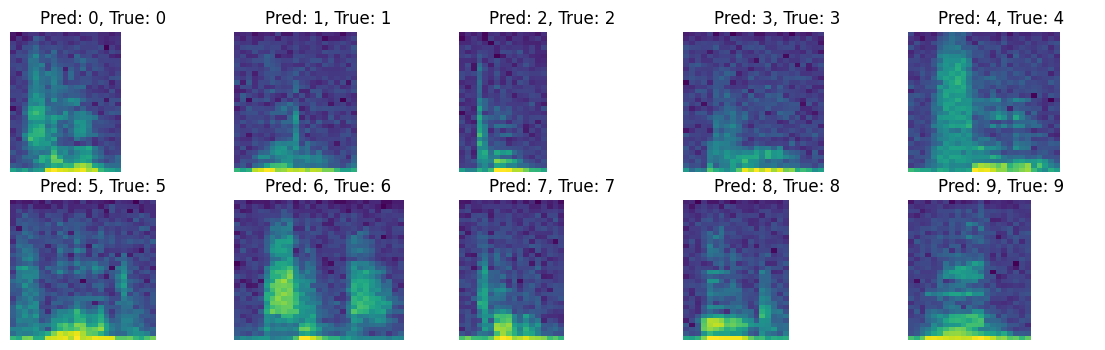

In [9]:
import matplotlib.pyplot as plt

# Choose a set of instances to explain for each number (0-9)
numbers_idx = []
for i in range(10):
    # Find the index of the first instance of each label in the test set
    idx = np.where(test_labels == i)[0][0]
    numbers_idx.append(idx)

rows = 2
cols = 5
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 4))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    idx = numbers_idx[i]
    plot_spectrogram(np.squeeze(test_audio[idx]), ax)
    ax.set_title(f'Pred: {y_pred[idx]}, True: {y_true[idx]}')
    ax.axis('off')

plt.show()